Generate 10-year average precipitation bias map

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import xarray as xr

from dask.diagnostics import ProgressBar
from matplotlib import pyplot as plt

from fme_diags.utils import load_config, open_autoregressive_inference, open_baseline

_ = xr.set_options(keep_attrs=True)

In [2]:
CONFIG_KEY = "topo-lr3.00e-04"
BASELINE_KEY = "baseline"
PREDS_START_DATE = "0031-01-01"
FLIP_LAT = False
CHUNKS = {"timestep": 178}

config = load_config("./preds.yaml")

In [3]:
ds = open_autoregressive_inference(config[CONFIG_KEY]["url"], start=PREDS_START_DATE, flip_lat=FLIP_LAT, chunks=CHUNKS)
ds

,Array,Chunk
Bytes,7.05 GiB,88.00 MiB
Shape,"(2, 1, 14597, 180, 360)","(2, 1, 178, 180, 360)"
Count,167 Tasks,83 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,7.05 GiB,88.00 MiB
Shape,"(2, 1, 14597, 180, 360)","(2, 1, 178, 180, 360)"
Count,167 Tasks,83 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [4]:
baseline_ds = open_baseline(config[BASELINE_KEY]["url"], start=PREDS_START_DATE, lat_coords=ds["lat"])
baseline_ds

,Array,Chunk
Bytes,3.52 GiB,1.19 MiB
Shape,"(14600, 180, 360)","(124, 7, 360)"
Count,3480 Tasks,3120 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,3.52 GiB,1.19 MiB
Shape,"(14600, 180, 360)","(124, 7, 360)"
Count,3480 Tasks,3120 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


Plot SFNO biases.

In [5]:
da = ds["surface_precipitation_rate"]

bias = da.sel(source="prediction") - da.sel(source="target")

with ProgressBar():
    time_mean_bias = bias.mean("time").compute()

[########################################] | 100% Completed | 24.1s


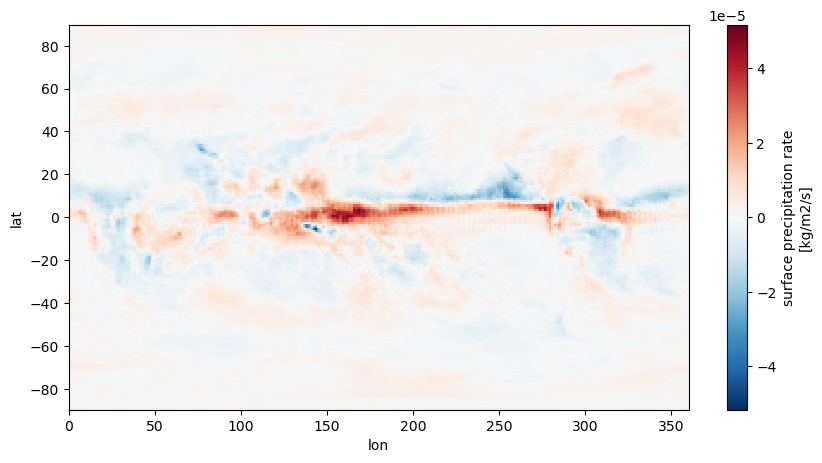

In [6]:
time_mean_bias.plot(figsize=(10, 5))
plt.show()

Plot bias of last 10 years of training set.

In [7]:
baseline_da = baseline_ds["surface_precipitation_rate"]

baseline_bias = baseline_da - da.sel(source="target", sample=0)

with ProgressBar():
    time_mean_baseline_bias = baseline_bias.mean("time").compute()

[########################################] | 100% Completed | 27.9s


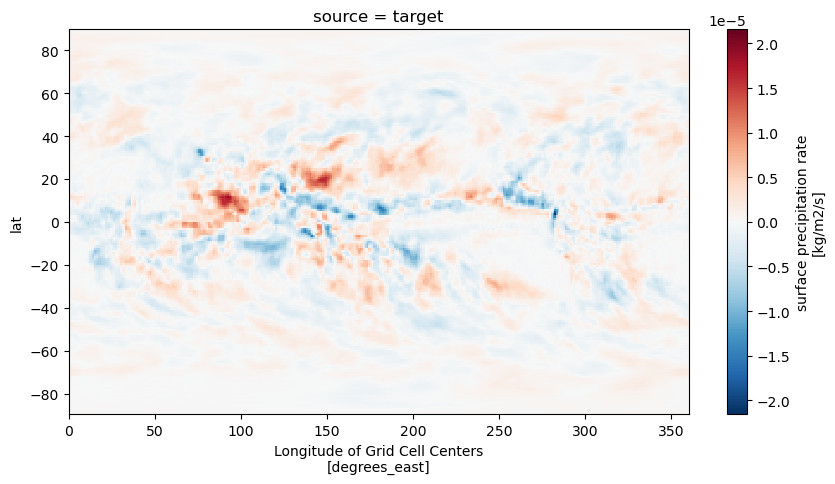

In [8]:
time_mean_baseline_bias.plot(figsize=(10, 5))
plt.show()

Plot the SFNO and baseline biases together.

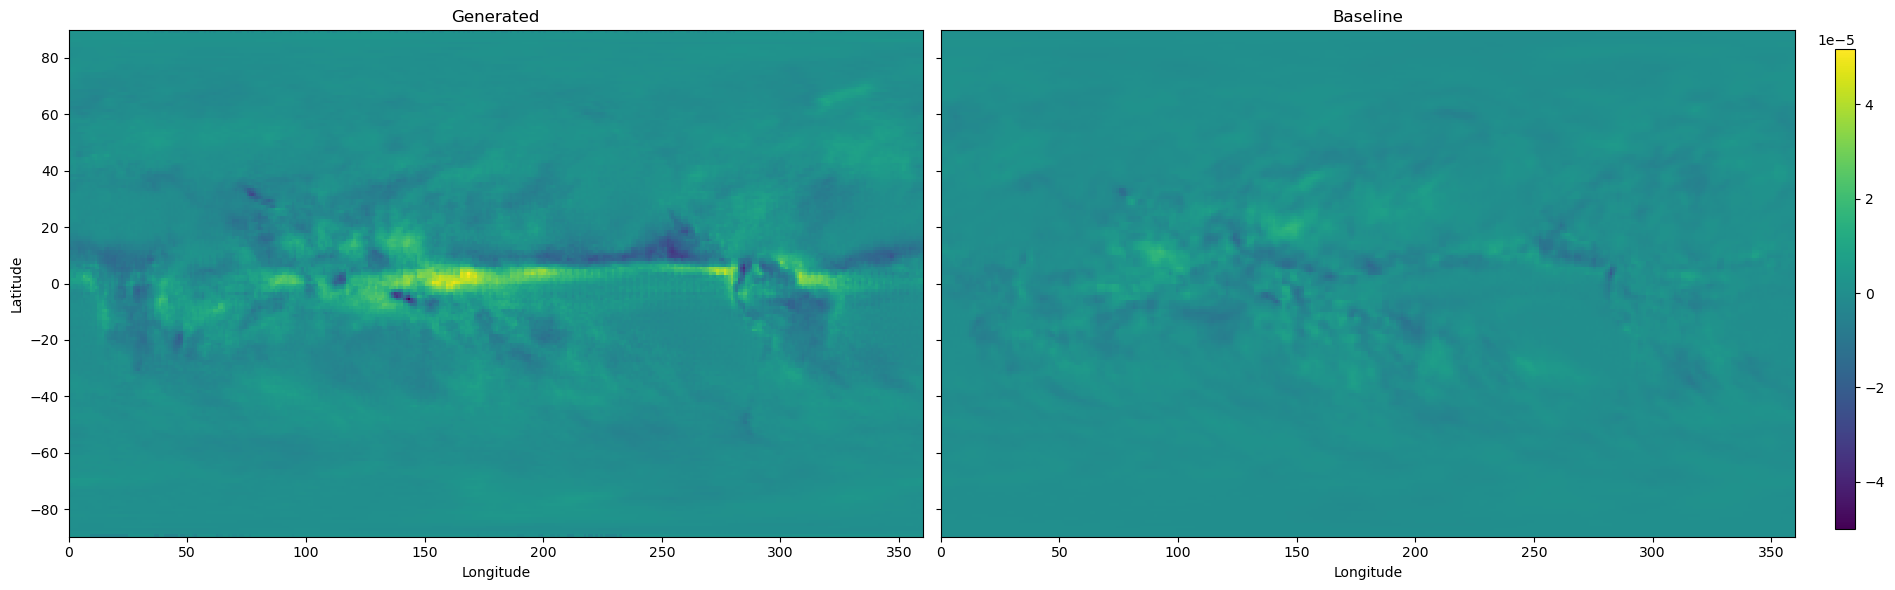

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs = axs.flatten()

vmin, vmax = time_mean_bias.min().item(), time_mean_bias.max().item()

time_mean_bias.plot(ax=axs[0], vmin=vmin, vmax=vmax, add_colorbar=False)
im = time_mean_baseline_bias.plot(ax=axs[1], vmin=vmin, vmax=vmax, add_colorbar=False)

axs[0].set_title("Generated")
axs[0].set_xlabel("Longitude")
axs[0].set_ylabel("Latitude")
axs[1].set_title("Baseline")
axs[1].set_xlabel("Longitude")
axs[1].set_ylabel("")
axs[1].yaxis.set_tick_params(labelleft=False)

plt.tight_layout()

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.11, 0.01, 0.8])
fig.colorbar(im, cax=cbar_ax, orientation="vertical")

fig.show()